In [1]:
import numpy as np
import ROOT
from math import exp as expo
from math import cos as cosine
exp=np.vectorize(expo)
cos=np.vectorize(cosine)
import matplotlib.pylab as plt
from matplotlib.pyplot import figure
from BlindersPy3 import Blinders
from BlindersPy3 import FitType
import scipy.optimize as opt

Welcome to JupyROOT 6.24/06


In [2]:
file = ROOT.TFile.Open("run3a_Ta_2_start.root")
#direc = file.Get("QFillByFillAnalyzerDB")
hist = ROOT.TH1D()
hist = file.Get("calo_histogram_sum_ratio")
hcov = ROOT.TH2D()
hcov = file.Get("hcov")



In [3]:
getBlinded = Blinders(FitType.Omega_a, "Ritwika's new  Blinding")

 + ++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++ +
 +                                                                      +
 +           You have chose to blind your fitting according to          +
 +                omega_ref * (1 + (R +/- deltaR) *10^{-6})             +
 +                                                                      +
 + ++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++ +


In [4]:
fit_start=32100
fit_stop=305000
fit_range=hist.FindBin(fit_stop)-hist.FindBin(fit_start)+1

T_a_true=4365.411
nbinshift=int((0.5*T_a_true)/hist.GetBinWidth(1))
T_a=2*nbinshift*hist.GetBinWidth(1)

y_val=np.empty(fit_range)
y_err=np.empty(fit_range)
x_val=np.empty(fit_range)

for ibin in range (0,fit_range):
    y_val[ibin]=hist.GetBinContent(ibin+hist.FindBin(fit_start))
    y_err[ibin]=hist.GetBinError(ibin+hist.FindBin(fit_start))
    x_val[ibin]=hist.GetBinCenter(ibin+hist.FindBin(fit_start))
    

y_cov = np.empty(shape=(fit_range,fit_range))

for irow in range (0, fit_range):
      for icol in range(0, fit_range):
            y_cov[irow][icol]=hcov.GetBinContent(irow+hist.FindBin(fit_start),icol+hist.FindBin(fit_start))

In [5]:
print(y_cov[0][0])
mat=np.linalg.eigvalsh(y_cov)
for irow in range (0, fit_range):
    if mat[irow]<=0:
        print(irow,"\n")

3.3149736105689885e-09


In [6]:
def fit_func(time: np.double,
             asym: np.double = 0.0, 
             R: np.double = 0.0, 
             phi: np.double = 0.0,
             asym_cbo = 0.0,
             tau_cbo = 0.0,
             omega_cbo = 0.0,
             phi_cbo = 0.0,
             asym_cbo_A = 0.0,
             phi_cbo_A=0.0,
             A_cbo_phi= 0.0,
             phi_cbo_phi=0.0,
             asym_vw= 0.0,
             tau_vw = 0.0,
             omega_vw = 0.0,
             phi_vw = 0.0,
             asym_vbo= 0.0,
             tau_vbo = 0.0,
             omega_vbo = 0.0,
             phi_vbo = 0.0,
             asym_2cbo= 0.0,
             phi_2cbo = 0.0,
             tau_rlx = 0.0,
             A_cbot = 0.0,
             #tau_cbot = 0.0,
             A_cbovw = 0.0,
             phi_cbovw = 0.0)-> np.double:
    
    #A_cbot=0.007
    tau_cbot=24400
    
    tau_cbovw = 17680,
    omega_cbovw = 0.012,
    
    omega_cbot=omega_cbo*(1+A_cbot*exp(-time/tau_cbot))
    omega_cbotf=omega_cbo*(1+A_cbot*exp(-(time+T_a/2)/tau_cbot))
    omega_cbotb=omega_cbo*(1+A_cbot*exp(-(time-T_a/2)/tau_cbot))
    
    Ncbo=(1 + asym_cbo*exp(-time/tau_cbo)*cos(omega_cbot*time - phi_cbo))
    Ncbof=(1+ asym_cbo*exp(-(time + T_a/2)/tau_cbo)*cos(omega_cbotf*(time + T_a/2) - phi_cbo))
    Ncbob=(1+ asym_cbo*exp(-(time - T_a/2)/tau_cbo)*cos(omega_cbotb*(time - T_a/2) - phi_cbo))
    
    Acbo=(1+ asym_cbo_A*exp(-time/tau_cbo)*cos(omega_cbot*time - phi_cbo_A));
    Acbof=(1+ asym_cbo_A*exp(-(time + T_a/2)/tau_cbo)*cos(omega_cbotf*(time + T_a/2) - phi_cbo_A))
    Acbob=(1+ asym_cbo_A*exp(-(time - T_a/2)/tau_cbo)*cos(omega_cbotb*(time - T_a/2) - phi_cbo_A))
    
    phicbo=(A_cbo_phi*exp(-time/tau_cbo)*cos(omega_cbot*time - phi_cbo_phi))
    phicbof=(A_cbo_phi*exp(-(time + T_a/2)/tau_cbo)*cos(omega_cbotf*(time + T_a/2) - phi_cbo_phi))
    phicbob=(A_cbo_phi*exp(-(time - T_a/2)/tau_cbo)*cos(omega_cbotb*(time - T_a/2) - phi_cbo_phi))
    
    Nvw=(1+ asym_vw*exp(-time/tau_vw)*cos(omega_vw*time - phi_vw))
    Nvwf=(1+ asym_vw*exp(-(time + T_a/2)/tau_vw)*cos(omega_vw*(time + T_a/2) - phi_vw))
    Nvwb=(1+ asym_vw*exp(-(time - T_a/2)/tau_vw)*cos(omega_vw*(time - T_a/2) - phi_vw))
    
    Nvbo=(1+ asym_vbo*exp(-time/tau_vbo)*cos(omega_vbo*time - phi_vbo))
    Nvbof=(1+ asym_vbo*exp(-(time + T_a/2)/tau_vbo)*cos(omega_vbo*(time + T_a/2) - phi_vbo))
    Nvbob=(1+ asym_vbo*exp(-(time - T_a/2)/tau_vbo)*cos(omega_vbo*(time - T_a/2) - phi_vbo))
    
    N2cbo=(asym_2cbo*exp(-2*time/tau_cbo)*cos(2*omega_cbot*time - phi_2cbo))
    N2cbof=(asym_2cbo*exp(-2*(time + T_a/2)/tau_cbo)*cos(2*omega_cbotf*(time + T_a/2) - phi_2cbo))
    N2cbob=(asym_2cbo*exp(-2*(time - T_a/2)/tau_cbo)*cos(2*omega_cbotb*(time - T_a/2) - phi_2cbo))
    
    Ncbovw=(1+ A_cbovw*exp(-time/tau_cbovw)*cos(omega_cbovw*time - phi_cbovw))
    Ncbovwf=(1+ A_cbovw*exp(-(time + T_a/2)/tau_cbovw)*cos(omega_cbovw*(time + T_a/2) - phi_cbovw))
    Ncbovwb=(1+ A_cbovw*exp(-(time - T_a/2)/tau_cbovw)*cos(omega_cbovw*(time - T_a/2) - phi_cbovw))

    
    Ncbo=Ncbo+N2cbo
    Ncbof=Ncbof+N2cbof
    Ncbob=Ncbob+N2cbob

    
    f=(1+ asym*exp(-time/tau_rlx)*Acbo*cos((getBlinded.paramToFreq(R)/1000.)*time - phi - phicbo))

    ff=(1+ asym*exp(-(time+T_a/2)/tau_rlx)*Acbof*cos((getBlinded.paramToFreq(R)/1000.)*(time + T_a/2) - phi - phicbof))

    fb=(1+ asym*exp(-(time-T_a/2)/tau_rlx)*Acbob*cos((getBlinded.paramToFreq(R)/1000.)*(time - T_a/2) - phi - phicbob))

    
    return (2*f*Ncbo*Nvw*Nvbo*Ncbovw - ff*Ncbof*Nvwf*Nvbof*Ncbovwf - fb*Ncbob*Nvwb*Nvbob*Ncbovwb)/(2*f*Ncbo*Nvw*Nvbo*Ncbovw + ff*Ncbof*Nvwf*Nvbof*Ncbovwf + fb*Ncbob*Nvwb*Nvbob*Ncbovwb)

In [7]:
p_init=[2.28839e-01,
        0.000000,
        4.02000e+00,
        2.42604e-03,
        2.54062e+05,
        2.330e-03,
        5.56481e-01,
        6.91318e-04,
        -5.78075e+00,
        6.39026e-05,
        3.52887e+01,
        2.36536e-04,
        1.38419e+05,
        1.389e-02,
        2.73495e-01,
        -1.00112e-03,
        3.48295e+04,
        1.407e-02,
        -1.99555e+01,
        1.10668e-04,
        3.06805e+00,
        3.7000e+08,
        0.0047,
        #23100,
        0.00014,
        4.2]

In [8]:
pars2, cov2 = opt.curve_fit(f=fit_func, xdata=x_val, ydata=y_val, p0=p_init, sigma=y_err)

In [9]:
p_init=pars2

In [10]:
pars_final, cov_final = opt.curve_fit(f=fit_func, xdata=x_val, ydata=y_val, p0=p_init, sigma=y_cov)

In [11]:
# Get the standard deviations of the parameters (square roots of the # diagonal of the covariance)
stdevs = np.sqrt(np.diag(cov_final))

In [12]:
for ipar in range(0,25):
    print(pars_final[ipar],"       +-  ",stdevs[ipar],"  \n")

0.22941528102466466        +-   1.3480871538417092e-05   

-35.37466404436413        +-   0.3858701990966921   

4.02308709325001        +-   5.956265884396093e-05   

0.0018690294547928227        +-   2.128355832079454e-05   

230541.7748251206        +-   7266.277716933774   

0.0023296876724988977        +-   3.0981238565822784e-07   

-0.3342929629078053        +-   0.043410823900547596   

0.000390037182301874        +-   6.132212597406785e-05   

-6.5787146654667215        +-   0.16156315909741997   

-7.79517607851952e-05        +-   6.192886541791748e-05   

35.2620028428181        +-   0.7942959800965019   

0.000428396308943006        +-   3.4187835447304744e-05   

95024.03985605389        +-   10365.930006606168   

0.013891956326095793        +-   1.1473268553790374e-06   

-0.27133889808811096        +-   0.07971285625590394   

-0.0032546443147631753        +-   0.0005996632500908252   

16971.96860029457        +-   1326.7974986886863   

0.01409245481280514        +-  

In [13]:
pars_final

array([ 2.29415281e-01, -3.53746640e+01,  4.02308709e+00,  1.86902945e-03,
        2.30541775e+05,  2.32968767e-03, -3.34292963e-01,  3.90037182e-04,
       -6.57871467e+00, -7.79517608e-05,  3.52620028e+01,  4.28396309e-04,
        9.50240399e+04,  1.38919563e-02, -2.71338898e-01, -3.25464431e-03,
        1.69719686e+04,  1.40924548e-02, -1.91496236e+01,  1.15136703e-04,
        3.38538694e+00,  3.45917948e+08,  5.90757915e-03, -2.60558779e-03,
        1.11185608e+01])

In [14]:
stdevs

array([1.34808715e-05, 3.85870199e-01, 5.95626588e-05, 2.12835583e-05,
       7.26627772e+03, 3.09812386e-07, 4.34108239e-02, 6.13221260e-05,
       1.61563159e-01, 6.19288654e-05, 7.94295980e-01, 3.41878354e-05,
       1.03659300e+04, 1.14732686e-06, 7.97128563e-02, 5.99663250e-04,
       1.32679750e+03, 4.63360761e-06, 1.85660401e-01, 1.34862491e-05,
       1.43662889e-01, 6.53002162e+07, 1.94166150e-03, 1.30567015e-03,
       4.97942574e-01])

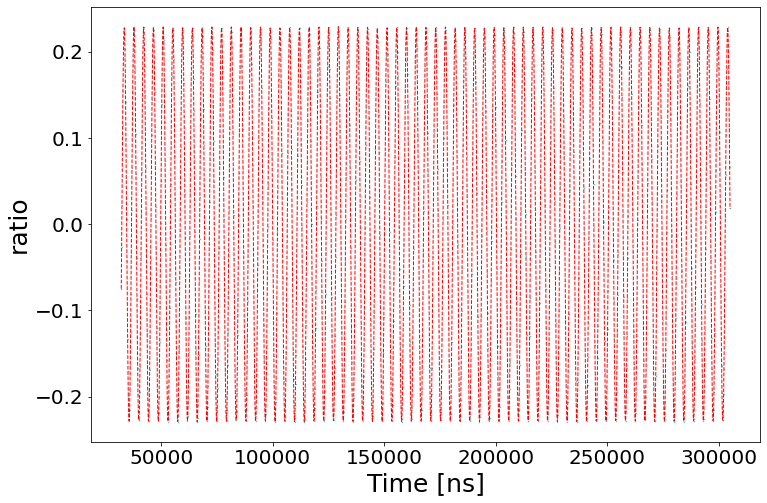

In [15]:
# Plot the noisy exponential data
plt.figure(figsize=(12,8))
plt.rc('xtick', labelsize=20) 
plt.rc('ytick', labelsize=20) 
plt.scatter(x_val, y_val, s=0.1, color='#00b3b3', label='Data')
plt.plot(x_val, fit_func(x_val, *pars_final), linestyle='--', linewidth=1, color='red')
plt.xlabel('Time [ns]',fontsize=25)
plt.ylabel('ratio',fontsize=25)
#plt.ylim([0.0, 6000000000])
#plt.xlim([100000,150000])
plt.show()

In [16]:
# Calculate the residuals
res = (y_val - fit_func(x_val, *pars_final))/y_err

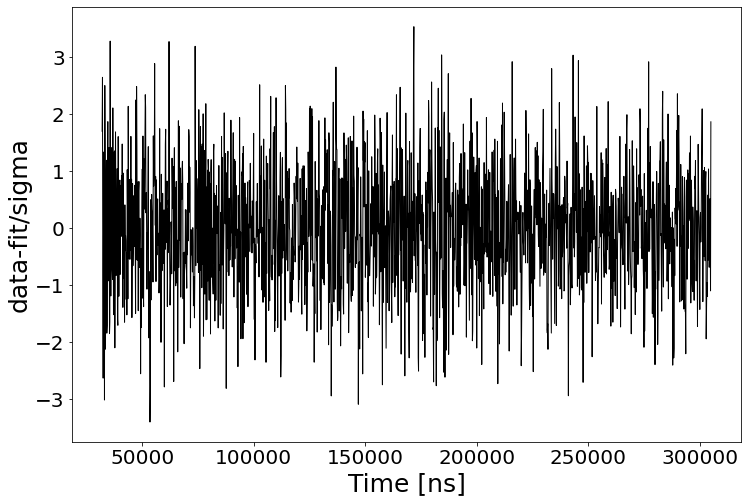

In [17]:
# Plot the noisy exponential data
plt.figure(figsize=(12,8))
plt.rc('xtick', labelsize=20) 
plt.rc('ytick', labelsize=20) 
plt.plot(x_val, res, linestyle='solid', linewidth=1, color='black')
plt.xlabel('Time [ns]',fontsize=25)
plt.ylabel('data-fit/sigma',fontsize=25)
plt.savefig('run2all_res.jpg')

In [18]:
stdevs

array([1.34808715e-05, 3.85870199e-01, 5.95626588e-05, 2.12835583e-05,
       7.26627772e+03, 3.09812386e-07, 4.34108239e-02, 6.13221260e-05,
       1.61563159e-01, 6.19288654e-05, 7.94295980e-01, 3.41878354e-05,
       1.03659300e+04, 1.14732686e-06, 7.97128563e-02, 5.99663250e-04,
       1.32679750e+03, 4.63360761e-06, 1.85660401e-01, 1.34862491e-05,
       1.43662889e-01, 6.53002162e+07, 1.94166150e-03, 1.30567015e-03,
       4.97942574e-01])

In [19]:
fou=abs(np.fft.fft(res))

In [20]:
#xfft=np.empty(fit_range)
xfft= np.linspace(0,6.667,num=fit_range)
xfft[800]

2.9305494505494507

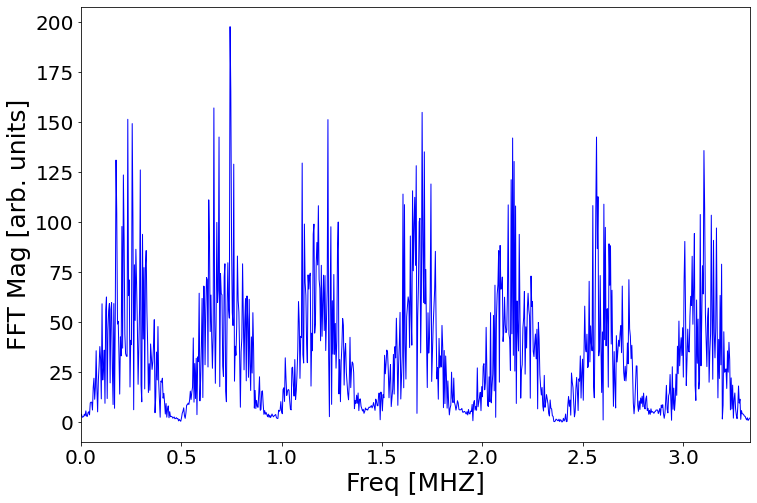

In [21]:
plt.figure(figsize=(12,8))
plt.rc('xtick', labelsize=20) 
plt.rc('ytick', labelsize=20) 
plt.plot(xfft, fou, linestyle='solid', linewidth=1, color='blue')
plt.xlim([0,6.667/2])
plt.xlabel('Freq [MHZ]',fontsize=25)
plt.ylabel('FFT Mag [arb. units]',fontsize=25)
plt.savefig('run2all_fft.jpg')

In [22]:
chi2=np.dot((np.transpose(y_val-fit_func(x_val, *pars_final))),(np.dot((np.linalg.inv(y_cov)),(y_val-fit_func(x_val, *pars_final)))))

In [23]:
chi2

1792.4609909051069

In [24]:
ndf=fit_range-len(pars_final)

In [25]:
red_chi2=chi2/ndf

In [26]:
red_chi2

0.9980295049583

In [27]:
ndf

1796

In [28]:
def fit_func_noTVC(time: np.double,
             asym: np.double = 0.0, 
             R: np.double = 0.0, 
             phi: np.double = 0.0,
             asym_cbo = 0.0,
             tau_cbo = 0.0,
             omega_cbo = 0.0,
             phi_cbo = 0.0,
             asym_cbo_A = 0.0,
             phi_cbo_A=0.0,
             A_cbo_phi= 0.0,
             phi_cbo_phi=0.0,
             asym_vw= 0.0,
             tau_vw = 0.0,
             omega_vw = 0.0,
             phi_vw = 0.0,
             asym_vbo= 0.0,
             tau_vbo = 0.0,
             omega_vbo = 0.0,
             phi_vbo = 0.0,
             asym_2cbo= 0.0,
             phi_2cbo = 0.0,
             tau_rlx = 0.0,
             A_cbovw = 0.0,
             phi_cbovw = 0.0)-> np.double:
    
    tau_cbovw = 17680,
    omega_cbovw = 0.012,
    
    Ncbo=(1 + asym_cbo*exp(-time/tau_cbo)*cos(omega_cbo*time - phi_cbo))
    Ncbof=(1+ asym_cbo*exp(-(time + T_a/2)/tau_cbo)*cos(omega_cbo*(time + T_a/2) - phi_cbo))
    Ncbob=(1+ asym_cbo*exp(-(time - T_a/2)/tau_cbo)*cos(omega_cbo*(time - T_a/2) - phi_cbo))
    
    Acbo=(1+ asym_cbo_A*exp(-time/tau_cbo)*cos(omega_cbo*time - phi_cbo_A));
    Acbof=(1+ asym_cbo_A*exp(-(time + T_a/2)/tau_cbo)*cos(omega_cbo*(time + T_a/2) - phi_cbo_A))
    Acbob=(1+ asym_cbo_A*exp(-(time - T_a/2)/tau_cbo)*cos(omega_cbo*(time - T_a/2) - phi_cbo_A))
    
    phicbo=(A_cbo_phi*exp(-time/tau_cbo)*cos(omega_cbo*time - phi_cbo_phi))
    phicbof=(A_cbo_phi*exp(-(time + T_a/2)/tau_cbo)*cos(omega_cbo*(time + T_a/2) - phi_cbo_phi))
    phicbob=(A_cbo_phi*exp(-(time - T_a/2)/tau_cbo)*cos(omega_cbo*(time - T_a/2) - phi_cbo_phi))
    
    Nvw=(1+ asym_vw*exp(-time/tau_vw)*cos(omega_vw*time - phi_vw))
    Nvwf=(1+ asym_vw*exp(-(time + T_a/2)/tau_vw)*cos(omega_vw*(time + T_a/2) - phi_vw))
    Nvwb=(1+ asym_vw*exp(-(time - T_a/2)/tau_vw)*cos(omega_vw*(time - T_a/2) - phi_vw))
    
    Nvbo=(1+ asym_vbo*exp(-time/tau_vbo)*cos(omega_vbo*time - phi_vbo))
    Nvbof=(1+ asym_vbo*exp(-(time + T_a/2)/tau_vbo)*cos(omega_vbo*(time + T_a/2) - phi_vbo))
    Nvbob=(1+ asym_vbo*exp(-(time - T_a/2)/tau_vbo)*cos(omega_vbo*(time - T_a/2) - phi_vbo))
    
    N2cbo=(asym_2cbo*exp(-2*time/tau_cbo)*cos(2*omega_cbo*time - phi_2cbo))
    N2cbof=(asym_2cbo*exp(-2*(time + T_a/2)/tau_cbo)*cos(2*omega_cbo*(time + T_a/2) - phi_2cbo))
    N2cbob=(asym_2cbo*exp(-2*(time - T_a/2)/tau_cbo)*cos(2*omega_cbo*(time - T_a/2) - phi_2cbo))
    
    Ncbovw=(1+ A_cbovw*exp(-time/tau_cbovw)*cos(omega_cbovw*time - phi_cbovw))
    Ncbovwf=(1+ A_cbovw*exp(-(time + T_a/2)/tau_cbovw)*cos(omega_cbovw*(time + T_a/2) - phi_cbovw))
    Ncbovwb=(1+ A_cbovw*exp(-(time - T_a/2)/tau_cbovw)*cos(omega_cbovw*(time - T_a/2) - phi_cbovw))

    
    Ncbo=Ncbo+N2cbo
    Ncbof=Ncbof+N2cbof
    Ncbob=Ncbob+N2cbob

    
    f=(1+ asym*exp(-time/tau_rlx)*Acbo*cos((getBlinded.paramToFreq(R)/1000.)*time - phi - phicbo))

    ff=(1+ asym*exp(-(time+T_a/2)/tau_rlx)*Acbof*cos((getBlinded.paramToFreq(R)/1000.)*(time + T_a/2) - phi - phicbof))

    fb=(1+ asym*exp(-(time-T_a/2)/tau_rlx)*Acbob*cos((getBlinded.paramToFreq(R)/1000.)*(time - T_a/2) - phi - phicbob))

    
    return (2*f*Ncbo*Nvw*Nvbo*Ncbovw - ff*Ncbof*Nvwf*Nvbof*Ncbovwf - fb*Ncbob*Nvwb*Nvbob*Ncbovwb)/(2*f*Ncbo*Nvw*Nvbo*Ncbovw + ff*Ncbof*Nvwf*Nvbof*Ncbovwf + fb*Ncbob*Nvwb*Nvbob*Ncbovwb)

In [29]:
p_init_noTVC=[2.28839e-01,
        0.000000,
        4.02000e+00,
        2.42604e-03,
        2.54062e+05,
        2.330e-03,
        5.56481e-01,
        6.91318e-04,
        -5.78075e+00,
        6.39026e-05,
        3.52887e+01,
        2.36536e-04,
        1.38419e+05,
        1.389e-02,
        2.73495e-01,
        -1.00112e-03,
        3.48295e+04,
        1.407e-02,
        -1.99555e+01,
        1.10668e-04,
        3.06805e+00,
        3.7000e+08,
        0.00014,
        4.2]

In [30]:
pars2_noTVC, cov2_noTVC = opt.curve_fit(f=fit_func_noTVC, xdata=x_val, ydata=y_val, p0=p_init_noTVC, sigma=y_err)

In [31]:
p_init_noTVC=pars2_noTVC

In [32]:
pars_final_noTVC, cov_final_noTVC = opt.curve_fit(f=fit_func_noTVC, xdata=x_val, ydata=y_val, p0=p_init_noTVC, sigma=y_cov)

In [33]:
# Get the standard deviations of the parameters (square roots of the # diagonal of the covariance)
stdevs_noTVC = np.sqrt(np.diag(cov_final_noTVC))

In [34]:
for ipar in range(0,24):
    print(pars_final_noTVC[ipar],"       +-  ",stdevs_noTVC[ipar],"  \n")

0.2294142010716881        +-   1.3507549886450128e-05   

-35.374417735567995        +-   0.3869859493017156   

4.023086915271998        +-   5.970097106896037e-05   

0.0018696490928328704        +-   2.1346228825943957e-05   

230284.93151905766        +-   7270.537437453265   

0.002328842544036083        +-   1.364201667309884e-07   

-0.4617518177715117        +-   0.011311211412908107   

0.000391752129963566        +-   6.147264147454465e-05   

-6.700433997926092        +-   0.1564637573027694   

-7.688081251975253e-05        +-   6.207306422781689e-05   

35.104285469585385        +-   0.8077849753623944   

0.00042909067228030806        +-   3.4317304316016814e-05   

94859.69009901442        +-   10358.466889308207   

0.01389195301217498        +-   1.1504419019460838e-06   

-0.27159162665231584        +-   0.07988125198758081   

-0.003258667247235635        +-   0.0006018258374673626   

16964.196832155914        +-   1328.875376192301   

0.014092582404847917        +

In [35]:
chi2_noTVC=np.dot((np.transpose(y_val-fit_func_noTVC(x_val, *pars_final_noTVC))),(np.dot((np.linalg.inv(y_cov)),(y_val-fit_func_noTVC(x_val, *pars_final_noTVC)))))

In [36]:
chi2_noTVC

1801.777648586682

In [37]:
ndf=fit_range-len(pars_final_noTVC)

In [38]:
red_chi2=chi2_noTVC/ndf

In [39]:
red_chi2

1.0026586803487378

In [40]:
pars_final[1]-pars_final_noTVC[1]

-0.00024630879613596335